# 0. Merge Raw scRNA-seq Data and Process

This script loads raw count data (e.g., from Cell Ranger) for multiple samples,
merges them into a single AnnData object, adds sample information,
and then performs standard preprocessing, normalization, dimensionality reduction,
and clustering on the combined dataset.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import anndata as ad
from tqdm import tqdm
import random
from pathlib import Path
import seaborn as sns

In [2]:
# --- Configuration ---

# Set seeds for reproducibility
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)

PROJECT_DIR = "D:/Github/SRF_Linda_RNA"
WORKING_DIR = os.path.join(PROJECT_DIR, "combine_data")
os.chdir(WORKING_DIR)
sys.path.insert(0, WORKING_DIR)

# Define Input Directory for Raw Data
# Assumes Cell Ranger structure: INPUT_RAW_DATA_BASE/SAMPLE_NAME/outs/filtered_feature_bc_matrix/
INPUT_RAW_DATA_BASE = os.path.join(PROJECT_DIR, "cellranger_final_count_data")

# Define Output Directory
OUTPUT_DIR = os.path.join(WORKING_DIR, "results_from_raw")
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_file = os.path.join(OUTPUT_DIR, 'merged_raw_processed.h5ad')

# Define Samples to Merge
SAMPLES = ["Emx1_Ctrl", "Emx1_Mut", "Nestin_Ctrl", "Nestin_Mut"]

# Define QC Parameters
MIN_GENES_PER_CELL = 500 
MIN_CELLS_PER_GENE = 6
MAX_MITO_PERCENT = 20

# Define Processing Parameters
N_TOP_HVG = 3000
N_PCS = 50
LEIDEN_RESOLUTION = 0.4

## Load and Merge Raw Data

In [3]:
adata_list = []
print("Loading raw data for each sample...")

for sample in tqdm(SAMPLES, desc="Loading Samples"):
    # Path to the directory containing matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz
    sample_dir_path = os.path.join(INPUT_RAW_DATA_BASE, sample, "outs", "filtered_feature_bc_matrix")
    print(f"  Loading {sample} from directory: {sample_dir_path}")
    if not os.path.isdir(sample_dir_path):
        print(f"  Warning: Directory not found for sample {sample} at {sample_dir_path}. Skipping.")
        continue
    try:
        # Use read_10x_mtx for Matrix Market format
        adata_sample = sc.read_10x_mtx(sample_dir_path, cache=True) # cache=True can speed up subsequent loads
        adata_sample.var_names_make_unique()  # Ensure unique gene names

        # Add sample information
        adata_sample.obs['sample'] = sample
        # Add condition information
        if "Ctrl" in sample:
            adata_sample.obs['condition'] = 'Control'
        elif "Mut" in sample:
            adata_sample.obs['condition'] = 'Mutant'
        else:
            adata_sample.obs['condition'] = 'Unknown'

        # Add genotype information
        if "Emx1" in sample:
            adata_sample.obs['genotype'] = 'Emx1'
        elif "Nestin" in sample:
            adata_sample.obs['genotype'] = 'Nestin'
        else:
            adata_sample.obs['genotype'] = 'Unknown'

        adata_list.append(adata_sample)
        print(f"  Loaded {adata_sample.n_obs} cells and {adata_sample.n_vars} genes for {sample}")
    except Exception as e:
        print(f"  Error loading {sample}: {e}")

Loading raw data for each sample...


Loading Samples:   0%|          | 0/4 [00:00<?, ?it/s]

  Loading Emx1_Ctrl from directory: D:/Github/SRF_Linda_RNA\cellranger_final_count_data\Emx1_Ctrl\outs\filtered_feature_bc_matrix


Loading Samples:  25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

  Loaded 5062 cells and 33696 genes for Emx1_Ctrl
  Loading Emx1_Mut from directory: D:/Github/SRF_Linda_RNA\cellranger_final_count_data\Emx1_Mut\outs\filtered_feature_bc_matrix


Loading Samples:  50%|█████     | 2/4 [00:08<00:09,  4.56s/it]

  Loaded 6562 cells and 33696 genes for Emx1_Mut
  Loading Nestin_Ctrl from directory: D:/Github/SRF_Linda_RNA\cellranger_final_count_data\Nestin_Ctrl\outs\filtered_feature_bc_matrix


Loading Samples:  75%|███████▌  | 3/4 [00:15<00:05,  5.66s/it]

  Loaded 9013 cells and 33696 genes for Nestin_Ctrl
  Loading Nestin_Mut from directory: D:/Github/SRF_Linda_RNA\cellranger_final_count_data\Nestin_Mut\outs\filtered_feature_bc_matrix


Loading Samples: 100%|██████████| 4/4 [00:22<00:00,  5.67s/it]

  Loaded 10011 cells and 33696 genes for Nestin_Mut


In [4]:
if not adata_list:
    print("Error: No datasets were loaded. Exiting.")
    sys.exit(1)

print("\nConcatenating datasets...")
# Ensure all AnnData objects have the same variables (genes) before concatenating
# Using 'outer' join keeps all genes, filling missing values with 0
# Using 'inner' join keeps only common genes
adata_merged = ad.concat(adata_list, join='outer', label='sample_batch', index_unique='-') # index_unique adds sample suffix to barcodes
adata_merged.obs_names_make_unique() # Ensure unique cell barcodes after merging


print(f"Total cells in merged dataset: {adata_merged.n_obs}")
print(f"Total genes in merged dataset: {adata_merged.n_vars}")

# Make a copy of raw counts
adata_merged.raw = adata_merged.copy()


Concatenating datasets...
Total cells in merged dataset: 30648
Total genes in merged dataset: 33696


## Quality Control (QC) and Filtering


Performing QC and Filtering...
Data stored for before/after comparison
Initial cell count: 30648
Initial gene count: 33696
Calculated 95th percentile for max genes: 9243
Cells after min_genes filter (> 500): 29560 (removed 1088)
Cells after max_genes filter (< 9243): 28027 (removed 1533)
Cells after mito filter (< 20%): 28026 (removed 1)


d:\Programs\miniforge3\envs\bioinf\Lib\site-packages\scanpy\preprocessing\_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Genes after min_cells filter (6): 26881 (removed 6815)
QC and Filtering complete.

Creating quality control visualizations...
✅ Quality control visualizations saved as 'qc_before_after_comparison.png/pdf'


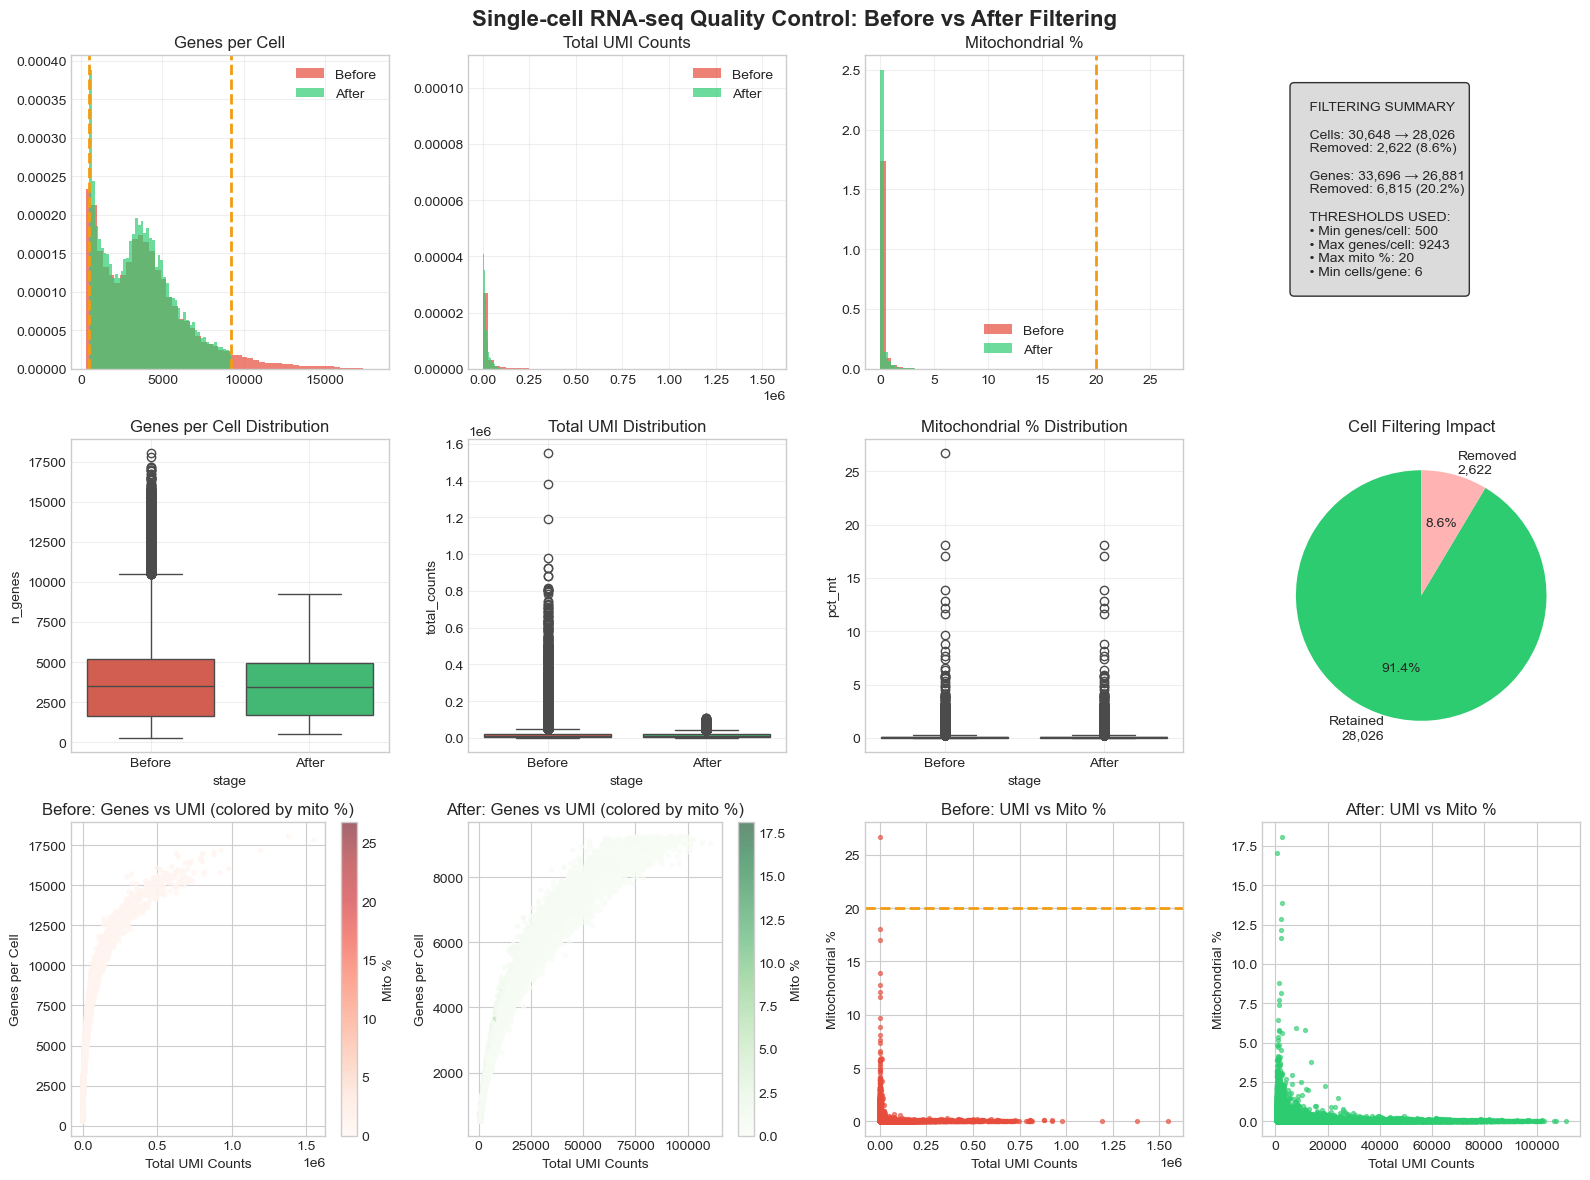


🎨 Visualization complete! Generated beautiful before/after QC plots.
📊 Original dataset: 30,648 cells, 33,696 genes
📊 Filtered dataset: 28,026 cells, 26,881 genes
🗑️  Removed: 2,622 cells (8.6%) and 6,815 genes (20.2%)


In [5]:

# Set aesthetic styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("\nPerforming QC and Filtering...")

# Calculate mitochondrial gene percentage
adata_merged.var['mt'] = adata_merged.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_merged, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# === STORE DATA BEFORE FILTERING ===
adata_before = adata_merged.copy()
print("Data stored for before/after comparison")

# --- Filtering ---
print(f"Initial cell count: {adata_merged.n_obs}")
print(f"Initial gene count: {adata_merged.n_vars}")

# Calculate the 95th percentile for max_genes
max_genes_percentile = np.percentile(adata_merged.obs['n_genes_by_counts'], 95)
print(f"Calculated 95th percentile for max genes: {max_genes_percentile:.0f}")

# --- Apply Filters ---
# 1. Filter cells based on min number of genes
n_obs_before = adata_merged.n_obs
adata_merged = adata_merged[np.array(adata_merged.obs.n_genes_by_counts) > MIN_GENES_PER_CELL]
print(f"Cells after min_genes filter (> {MIN_GENES_PER_CELL}): {adata_merged.n_obs} (removed {n_obs_before - adata_merged.n_obs})")

# 2. Filter cells based on max number of genes (percentile)
n_obs_before = adata_merged.n_obs
adata_merged = adata_merged[np.array(adata_merged.obs.n_genes_by_counts) < int(max_genes_percentile)]
print(f"Cells after max_genes filter (< {max_genes_percentile:.0f}): {adata_merged.n_obs} (removed {n_obs_before - adata_merged.n_obs})")

# 3. Filter cells based on mitochondrial content
n_obs_before = adata_merged.n_obs
adata_merged = adata_merged[np.array(adata_merged.obs.pct_counts_mt) < MAX_MITO_PERCENT]
print(f"Cells after mito filter (< {MAX_MITO_PERCENT}%): {adata_merged.n_obs} (removed {n_obs_before - adata_merged.n_obs})")

# 4. Filter genes based on minimum number of cells expressing them
n_vars_before = adata_merged.n_vars
sc.pp.filter_genes(adata_merged, min_cells=MIN_CELLS_PER_GENE)
print(f"Genes after min_cells filter ({MIN_CELLS_PER_GENE}): {adata_merged.n_vars} (removed {n_vars_before - adata_merged.n_vars})")

print("QC and Filtering complete.")

# === CREATE AESTHETIC VISUALIZATIONS ===
print("\nCreating quality control visualizations...")

def plot_qc_metrics_comparison(adata_before, adata_after, figsize=(16, 12)):
    """Create aesthetic before/after QC comparison plots"""
    
    # Colors
    before_color = '#E74C3C'  # Red
    after_color = '#2ECC71'   # Green
    threshold_color = '#F39C12'  # Orange
    
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    fig.suptitle('Single-cell RNA-seq Quality Control: Before vs After Filtering', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Calculate thresholds
    max_genes = np.percentile(adata_before.obs['n_genes_by_counts'], 95)
    
    # Row 1: Histograms
    # Genes per cell
    axes[0,0].hist(adata_before.obs['n_genes_by_counts'], bins=50, alpha=0.7, 
                   color=before_color, label='Before', density=True)
    axes[0,0].hist(adata_after.obs['n_genes_by_counts'], bins=50, alpha=0.7, 
                   color=after_color, label='After', density=True)
    axes[0,0].axvline(MIN_GENES_PER_CELL, color=threshold_color, linestyle='--', linewidth=2)
    axes[0,0].axvline(max_genes, color=threshold_color, linestyle='--', linewidth=2)
    axes[0,0].set_title('Genes per Cell')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Total UMI counts
    axes[0,1].hist(adata_before.obs['total_counts'], bins=50, alpha=0.7, 
                   color=before_color, label='Before', density=True)
    axes[0,1].hist(adata_after.obs['total_counts'], bins=50, alpha=0.7, 
                   color=after_color, label='After', density=True)
    axes[0,1].set_title('Total UMI Counts')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Mitochondrial percentage
    axes[0,2].hist(adata_before.obs['pct_counts_mt'], bins=50, alpha=0.7, 
                   color=before_color, label='Before', density=True)
    axes[0,2].hist(adata_after.obs['pct_counts_mt'], bins=50, alpha=0.7, 
                   color=after_color, label='After', density=True)
    axes[0,2].axvline(MAX_MITO_PERCENT, color=threshold_color, linestyle='--', linewidth=2)
    axes[0,2].set_title('Mitochondrial %')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Summary stats
    axes[0,3].axis('off')
    summary_text = f"""
    FILTERING SUMMARY
    
    Cells: {adata_before.n_obs:,} → {adata_after.n_obs:,}
    Removed: {adata_before.n_obs - adata_after.n_obs:,} ({((adata_before.n_obs - adata_after.n_obs)/adata_before.n_obs*100):.1f}%)
    
    Genes: {adata_before.n_vars:,} → {adata_after.n_vars:,}
    Removed: {adata_before.n_vars - adata_after.n_vars:,} ({((adata_before.n_vars - adata_after.n_vars)/adata_before.n_vars*100):.1f}%)
    
    THRESHOLDS USED:
    • Min genes/cell: {MIN_GENES_PER_CELL}
    • Max genes/cell: {max_genes:.0f}
    • Max mito %: {MAX_MITO_PERCENT}
    • Min cells/gene: {MIN_CELLS_PER_GENE}
    """
    axes[0,3].text(0.1, 0.9, summary_text, transform=axes[0,3].transAxes, 
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    # Row 2: Box plots
    # Prepare data for box plots
    df_before = pd.DataFrame({
        'n_genes': adata_before.obs['n_genes_by_counts'],
        'total_counts': adata_before.obs['total_counts'],
        'pct_mt': adata_before.obs['pct_counts_mt'],
        'stage': 'Before'
    })
    df_after = pd.DataFrame({
        'n_genes': adata_after.obs['n_genes_by_counts'],
        'total_counts': adata_after.obs['total_counts'],
        'pct_mt': adata_after.obs['pct_counts_mt'],
        'stage': 'After'
    })
    df_combined = pd.concat([df_before, df_after])
    
    # Box plots
    sns.boxplot(data=df_combined, x='stage', y='n_genes', ax=axes[1,0],
                hue='stage', palette=[before_color, after_color], legend=False)
    axes[1,0].set_title('Genes per Cell Distribution')
    axes[1,0].grid(True, alpha=0.3)
    
    sns.boxplot(data=df_combined, x='stage', y='total_counts', ax=axes[1,1],
                hue='stage', palette=[before_color, after_color], legend=False)
    axes[1,1].set_title('Total UMI Distribution')
    axes[1,1].grid(True, alpha=0.3)
    
    sns.boxplot(data=df_combined, x='stage', y='pct_mt', ax=axes[1,2],
                hue='stage', palette=[before_color, after_color], legend=False)
    axes[1,2].set_title('Mitochondrial % Distribution')
    axes[1,2].grid(True, alpha=0.3)
    
    # Pie chart showing filtering impact
    removed_cells = adata_before.n_obs - adata_after.n_obs
    retained_cells = adata_after.n_obs
    sizes = [retained_cells, removed_cells]
    labels = [f'Retained\n{retained_cells:,}', f'Removed\n{removed_cells:,}']
    colors = [after_color, '#FFB3B3']
    
    axes[1,3].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                  startangle=90)
    axes[1,3].set_title('Cell Filtering Impact')
    
    # Row 3: Scatter plots
    # Before filtering scatter
    scatter1 = axes[2,0].scatter(adata_before.obs['total_counts'], 
                                adata_before.obs['n_genes_by_counts'], 
                                c=adata_before.obs['pct_counts_mt'], 
                                cmap='Reds', alpha=0.6, s=8)
    axes[2,0].set_xlabel('Total UMI Counts')
    axes[2,0].set_ylabel('Genes per Cell')
    axes[2,0].set_title('Before: Genes vs UMI (colored by mito %)')
    plt.colorbar(scatter1, ax=axes[2,0], label='Mito %')
    
    # After filtering scatter
    scatter2 = axes[2,1].scatter(adata_after.obs['total_counts'], 
                                adata_after.obs['n_genes_by_counts'], 
                                c=adata_after.obs['pct_counts_mt'], 
                                cmap='Greens', alpha=0.6, s=8)
    axes[2,1].set_xlabel('Total UMI Counts')
    axes[2,1].set_ylabel('Genes per Cell')
    axes[2,1].set_title('After: Genes vs UMI (colored by mito %)')
    plt.colorbar(scatter2, ax=axes[2,1], label='Mito %')
    
    # Mitochondrial vs UMI before
    axes[2,2].scatter(adata_before.obs['total_counts'], 
                      adata_before.obs['pct_counts_mt'], 
                      color=before_color, alpha=0.6, s=8)
    axes[2,2].axhline(MAX_MITO_PERCENT, color=threshold_color, linestyle='--', linewidth=2)
    axes[2,2].set_xlabel('Total UMI Counts')
    axes[2,2].set_ylabel('Mitochondrial %')
    axes[2,2].set_title('Before: UMI vs Mito %')
    
    # Mitochondrial vs UMI after
    axes[2,3].scatter(adata_after.obs['total_counts'], 
                      adata_after.obs['pct_counts_mt'], 
                      color=after_color, alpha=0.6, s=8)
    axes[2,3].set_xlabel('Total UMI Counts')
    axes[2,3].set_ylabel('Mitochondrial %')
    axes[2,3].set_title('After: UMI vs Mito %')
    
    plt.tight_layout()
    return fig

# Create the comprehensive visualization
fig = plot_qc_metrics_comparison(adata_before, adata_merged)

# Save the figure
plt.savefig('qc_before_after_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('qc_before_after_comparison.pdf', bbox_inches='tight')

print("✅ Quality control visualizations saved as 'qc_before_after_comparison.png/pdf'")
plt.show()


print("\n🎨 Visualization complete! Generated beautiful before/after QC plots.")
print(f"📊 Original dataset: {adata_before.n_obs:,} cells, {adata_before.n_vars:,} genes")
print(f"📊 Filtered dataset: {adata_merged.n_obs:,} cells, {adata_merged.n_vars:,} genes")
print(f"🗑️  Removed: {adata_before.n_obs - adata_merged.n_obs:,} cells ({((adata_before.n_obs - adata_merged.n_obs)/adata_before.n_obs*100):.1f}%) and {adata_before.n_vars - adata_merged.n_vars:,} genes ({((adata_before.n_vars - adata_merged.n_vars)/adata_before.n_vars*100):.1f}%)")

In [6]:
# Check the data type
print("Data type:", adata_merged.X.dtype) # type: ignore

# Look at some actual values
print("Sample values:")
print(adata_merged.X[:5, :5].toarray() if hasattr(adata_merged.X, 'toarray') else adata_merged.X[:5, :5]) # type: ignore

# Check if all values are integers
if hasattr(adata_merged.X, 'toarray'):
    sample_data = adata_merged.X[:1000, :100].toarray() # type: ignore
else:
    sample_data = adata_merged.X[:1000, :100] # type: ignore

print("Are all sampled values integers?", np.all(sample_data == sample_data.astype(int)))
print("Min value:", sample_data.min())
print("Max value:", sample_data.max())

Data type: float32
Sample values:
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [39.  1.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [44.  2.  2.  0.  0.]]
Are all sampled values integers? True
Min value: 0.0
Max value: 164.0


Identifying top 3000 highly variable genes...


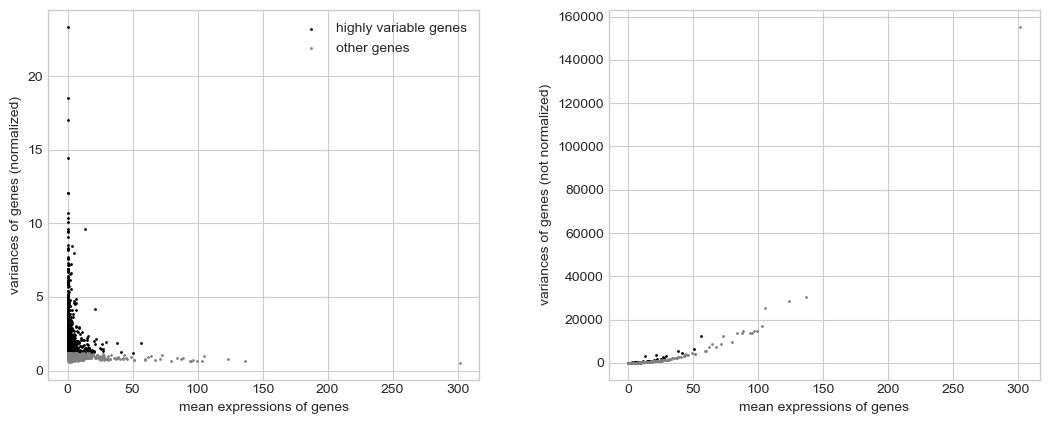

In [7]:
# Identify Highly Variable Genes (HVGs)
print(f"Identifying top {N_TOP_HVG} highly variable genes...")
sc.pp.highly_variable_genes(adata_merged, n_top_genes=N_TOP_HVG, flavor='seurat_v3')
sc.pl.highly_variable_genes(adata_merged, show=True)

## Normalization and Scaling

In [8]:
print("\nNormalizing and Scaling data...")

# Normalize counts per cell (library size normalization)
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)


Normalizing and Scaling data...


In [9]:
# Subset data to HVGs (optional, but often done before scaling and PCA)
# adata_merged = adata_merged[:, adata_merged.var.highly_variable]
# print(f"Subsetting to {adata_merged.n_vars} HVGs.")

In [10]:
# Scale data to unit variance and zero mean (regress out total counts and mito % if desired)
print("Scaling data...")
# sc.pp.scale(adata_merged, max_value=10, vars_to_regress=['total_counts', 'pct_counts_mt']) # Example regression
sc.pp.scale(adata_merged, max_value=10) # Simpler scaling

print("Normalization and Scaling complete.")

Scaling data...


d:\Programs\miniforge3\envs\bioinf\Lib\functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Normalization and Scaling complete.


In [11]:
print(adata_merged.layers)

Layers with keys: 


## Dimensionality Reduction


Performing Dimensionality Reduction (PCA and UMAP)...
Running PCA using 26881 genes...


d:\Programs\miniforge3\envs\bioinf\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


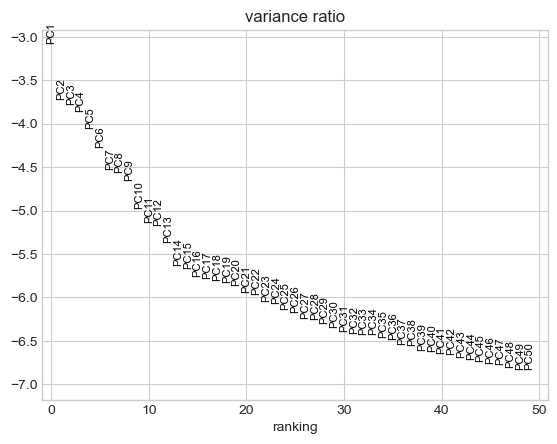

Computing neighborhood graph using 50 PCs...


d:\Programs\miniforge3\envs\bioinf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running UMAP...
Dimensionality Reduction complete.


In [12]:
print("\nPerforming Dimensionality Reduction (PCA and UMAP)...")

# Use HVGs for PCA if subsetting was done, otherwise uses all genes if not subsetted before scaling
print(f"Running PCA using {adata_merged.n_vars} genes...")
sc.tl.pca(adata_merged, n_comps=N_PCS, use_highly_variable=True, svd_solver='arpack') # Ensure HVGs are used if identified

sc.pl.pca_variance_ratio(adata_merged, log=True, n_pcs=N_PCS, show=True)

print(f"Computing neighborhood graph using {N_PCS} PCs...")
sc.pp.neighbors(adata_merged, n_neighbors=15, n_pcs=N_PCS)

print("Running UMAP...")
sc.tl.umap(adata_merged)

print("Dimensionality Reduction complete.")

## Clustering

In [13]:
adata_merged.write(Path('adata_merged_intermediate.h5ad'))

In [14]:
adata_merged = ad.read_h5ad('adata_merged_intermediate.h5ad')

In [15]:
print("\nPerforming Clustering (Leiden)...")

# Leiden clustering
print(f"Running Leiden clustering with resolution {LEIDEN_RESOLUTION}...")
sc.tl.leiden(adata_merged, resolution=LEIDEN_RESOLUTION, key_added=f'leiden_{LEIDEN_RESOLUTION}')

print("Clustering complete.")


Performing Clustering (Leiden)...
Running Leiden clustering with resolution 0.4...


C:\Users\janku\AppData\Local\Temp\ipykernel_28964\1269416446.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_merged, resolution=LEIDEN_RESOLUTION, key_added=f'leiden_{LEIDEN_RESOLUTION}')


Clustering complete.


## Visualization and Saving


Generating visualizations...
Plotting UMAP colored by sample...


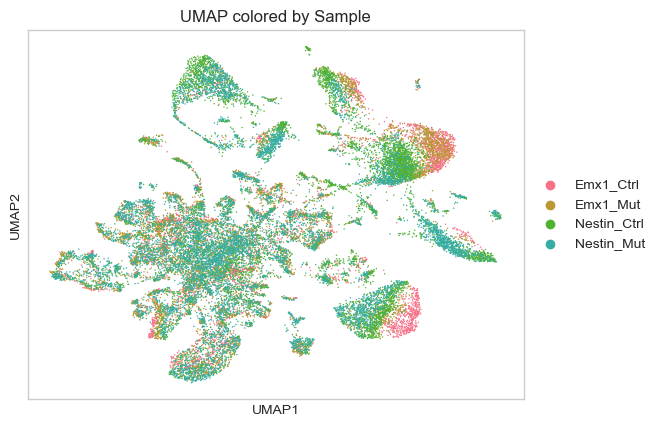

Plotting UMAP colored by condition...


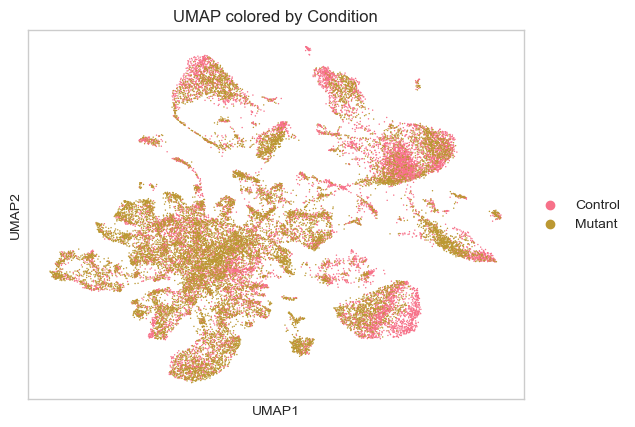

Plotting UMAP colored by genotype...


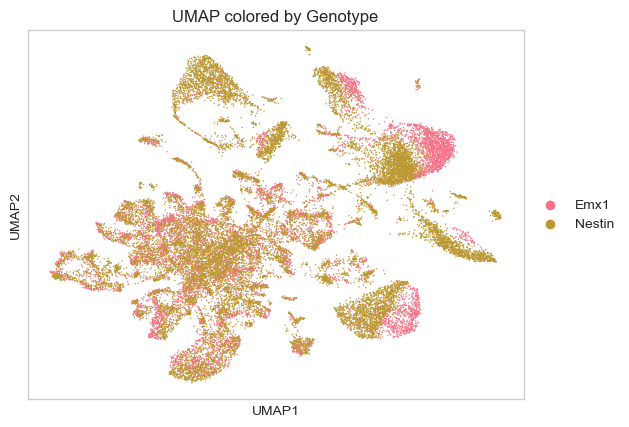

Plotting UMAP colored by leiden_0.4...


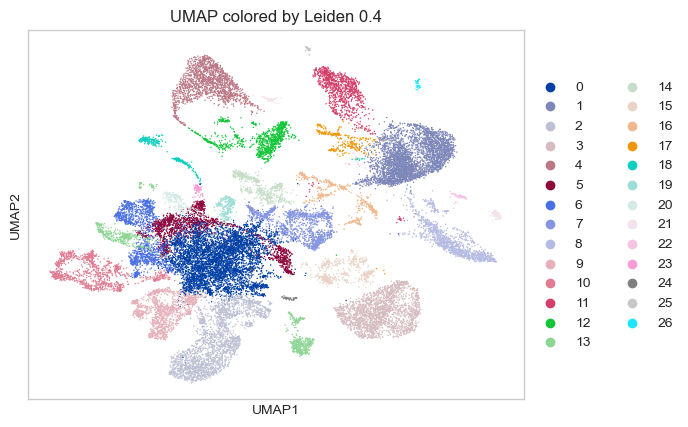

In [16]:
print("\nGenerating visualizations...")

# Create directory for plots if it doesn't exist
plot_dir = os.path.join(OUTPUT_DIR, "plots")
os.makedirs(plot_dir, exist_ok=True)
sc.settings.figdir = plot_dir

# Plot UMAP colored by sample, condition, genotype, and Leiden clusters
umap_plots = {
    'sample': 'sample',
    'condition': 'condition',
    'genotype': 'genotype',
    f'leiden_{LEIDEN_RESOLUTION}': f'leiden_{LEIDEN_RESOLUTION}'
}

for key, column in umap_plots.items():
    if column in adata_merged.obs:
        print(f"Plotting UMAP colored by {key}...")
        sc.pl.umap(adata_merged, color=column, legend_loc='right margin',
                   save=f"_umap_{key}.png", show=True,
                   title=f'UMAP colored by {key.replace("_", " ").title()}')
    else:
        print(f"Warning: Column '{column}' not found in adata_merged.obs. Skipping UMAP plot for {key}.")

## Post-Filtering Sample Summary &amp; Transcriptomic Complexity


Generating post-filtering sample summary and complexity plots...

--- Summary of Cells and Genes per Sample (Post-Filtering) ---
        sample  n_cells  median_genes_per_cell  median_umi_per_cell
0    Emx1_Ctrl     4397                 3677.0              10173.0
1     Emx1_Mut     5836                 3732.0              10897.0
2  Nestin_Ctrl     8422                 3032.0               7736.5
3   Nestin_Mut     9371                 3371.0              10206.0
Saved post-filtering summary to D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\post_filtering_sample_summary.csv

Creating transcriptomic complexity histograms for each sample...


C:\Users\janku\AppData\Local\Temp\ipykernel_28964\2984772067.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = adata_merged.obs.groupby('sample').agg(


✅ Sample complexity histograms saved to D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\plots\sample_complexity_histograms.png


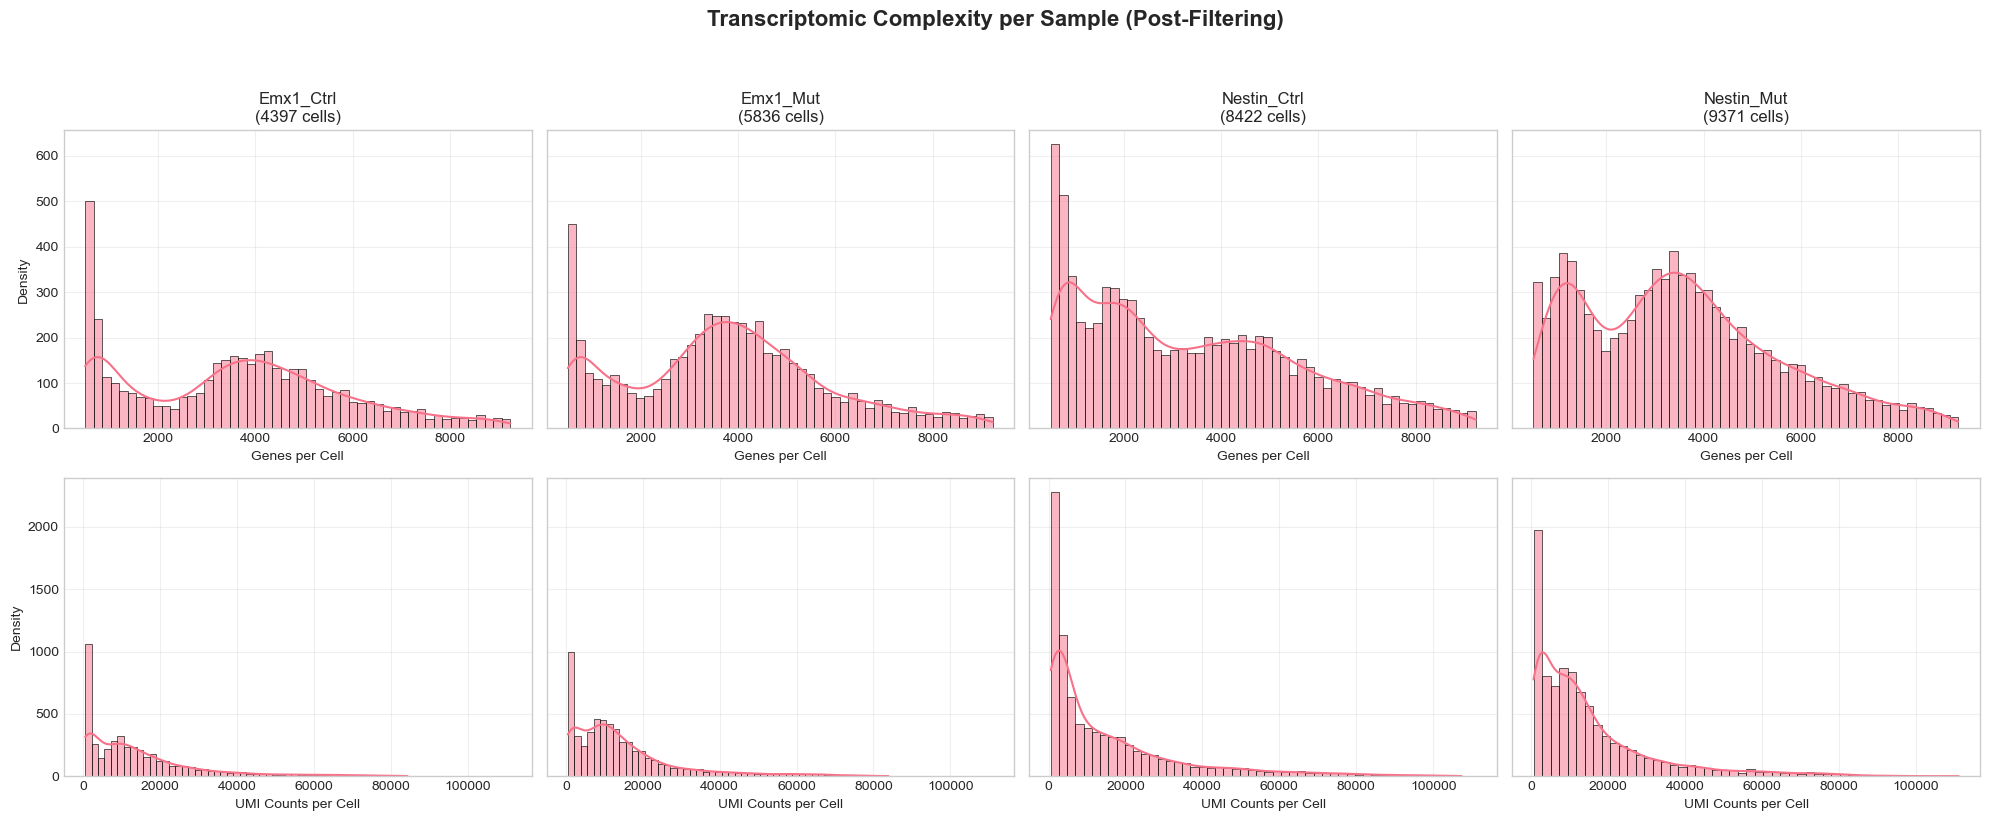


Summary generation complete!


In [18]:
print("\nGenerating post-filtering sample summary and complexity plots...")

# --- Create a summary DataFrame ---
# This contains the number of cells and genes for each sample after filtering
summary_df = adata_merged.obs.groupby('sample').agg(
    n_cells=('sample', 'size'),
    median_genes_per_cell=('n_genes_by_counts', 'median'),
    median_umi_per_cell=('total_counts', 'median')
).reset_index()

print("\n--- Summary of Cells and Genes per Sample (Post-Filtering) ---")
print(summary_df)
summary_csv_path = os.path.join(OUTPUT_DIR, "post_filtering_sample_summary.csv")
summary_df.to_csv(summary_csv_path, index=False)
print(f"Saved post-filtering summary to {summary_csv_path}")


# --- Create Histograms for Transcriptomic Complexity ---
print("\nCreating transcriptomic complexity histograms for each sample...")

# Get the list of samples
samples = adata_merged.obs['sample'].cat.categories.tolist()
n_samples = len(samples)

# Create a figure with subplots
# We'll have two rows of plots: one for genes per cell, one for UMI counts per cell
fig, axes = plt.subplots(2, n_samples, figsize=(5 * n_samples, 8), sharex='row', sharey='row')
fig.suptitle('Transcriptomic Complexity per Sample (Post-Filtering)', fontsize=16, fontweight='bold', y=1.02)

for i, sample in enumerate(samples):
    sample_obs = adata_merged.obs[adata_merged.obs['sample'] == sample]
    
    # Plot n_genes_by_counts
    sns.histplot(sample_obs['n_genes_by_counts'], bins=50, ax=axes[0, i], kde=True)
    axes[0, i].set_title(f'{sample}\n({sample_obs.shape[0]} cells)')
    axes[0, i].set_xlabel('Genes per Cell')
    axes[0, i].grid(True, alpha=0.3)
    if i == 0:
        axes[0, i].set_ylabel('Density')
    else:
        axes[0, i].set_ylabel('')


    # Plot total_counts
    sns.histplot(sample_obs['total_counts'], bins=50, ax=axes[1, i], kde=True)
    axes[1, i].set_xlabel('UMI Counts per Cell')
    axes[1, i].grid(True, alpha=0.3)
    if i == 0:
        axes[1, i].set_ylabel('Density')
    else:
        axes[1, i].set_ylabel('')

plt.tight_layout(rect=(0, 0, 1, 0.98))

# Save the figure
complexity_plot_path = os.path.join(plot_dir, 'sample_complexity_histograms.png')
plt.savefig(complexity_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Sample complexity histograms saved to {complexity_plot_path}")
plt.show()

print("\nSummary generation complete!")

In [17]:
# Save the processed merged datasetoutput_file = os.path.join(OUTPUT_DIR, 'merged_raw_processed.h5ad')
print(f"\nSaving processed merged dataset to {output_file}")
try:
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    adata_merged.write(Path(output_file))
    print("Successfully saved the AnnData object.")
except Exception as e:
    print(f"Error saving AnnData object: {e}")

print("\nScript finished!")

# # %% [markdown]
# # ## Add Alternative UMAP Embedding

# # %%
# alt_leiden_key = "leiden_0.8"
# print("\nLoading alternative UMAP embedding...")
# alt_adata_path = os.path.join(PROJECT_DIR, "combine_data", "Archive", "from_preprocessed_counts", "results", "all_samples_merged.h5ad")
# alt_umap_key = 'X_umap_alt' # Key to store the alternative UMAP

# # Load obs_names, UMAP coordinates, and leiden_0.8 clustering from the alternative file
# print(f"Loading obs_names, X_umap, obs['leiden_0.8'], DG_majority_voting, ISO_majority_voting, DG_conf_score, and ISO_conf_score from {alt_adata_path}")
# adata_alt_subset = ad.read_h5ad(alt_adata_path, backed='r') # Read in backed mode initially

# # %%
# adata_alt_subset.obs.columns
# adata_alt_subset.obs.ISO_majority_voting

# # %%

# # --- Explicitly load required .obs columns into memory ---
# print("Loading required .obs columns from alternative data into memory...")
# obs_cols_to_load = []
# if 'leiden_0.8' in adata_alt_subset.obs.columns:
#     obs_cols_to_load.append('leiden_0.8')
# if 'DG_majority_voting' in adata_alt_subset.obs.columns: 
#     obs_cols_to_load.append('DG_majority_voting')
# if 'ISO_majority_voting' in adata_alt_subset.obs.columns: 
#      obs_cols_to_load.append('ISO_majority_voting')
# if 'DG_conf_score' in adata_alt_subset.obs.columns: 
#      obs_cols_to_load.append('DG_conf_score')
# if 'ISO_conf_score' in adata_alt_subset.obs.columns: 
#     obs_cols_to_load.append('ISO_conf_score')

# if obs_cols_to_load:
#     adata_alt_obs_in_memory = adata_alt_subset.obs[obs_cols_to_load].copy()
#     # We also need the original obs_names
#     alt_obs_names_orig = adata_alt_subset.obs_names.to_list()
#     print(f"Loaded {len(obs_cols_to_load)} .obs columns and obs_names into memory.")
# else:
#     print("Warning: No required .obs columns found to load into memory.")
#     adata_alt_obs_in_memory = pd.DataFrame(index=adata_alt_subset.obs_names) # Empty df with index
#     alt_obs_names_orig = adata_alt_subset.obs_names.to_list()
# # Also load UMAP coordinates if present
# alt_umap_coords = None
# if 'X_umap' in adata_alt_subset.obsm_keys():
#     umap_data = adata_alt_subset.obsm['X_umap']
#     if hasattr(umap_data, 'toarray'):  # Check if it's a sparse matrix
#         alt_umap_coords = umap_data.toarray().copy()
#     else:  # Assume it's already a dense numpy array
#         alt_umap_coords = umap_data.copy()
#     print("Loaded X_umap coordinates into memory.")
# # Close the backed file connection if possible (optional, may help release resources)
# # adata_alt_subset.file.close()
# # ----------------------------------------------------------

# # Check if required data exists in the alternative file (using in-memory data now)
# alt_umap_present = alt_umap_coords is not None
# alt_leiden_key = 'leiden_0.8' # Keep original key name
# alt_leiden_present = alt_leiden_key in adata_alt_obs_in_memory.columns
# alt_dg_present = 'DG_majority_voting' in adata_alt_obs_in_memory.columns
# alt_iso_present = 'ISO_majority_voting' in adata_alt_obs_in_memory.columns
# alt_dg_conf_present = 'DG_conf_score' in adata_alt_obs_in_memory.columns
# alt_iso_conf_present = 'ISO_conf_score' in adata_alt_obs_in_memory.columns

# if not alt_umap_present:
#         print(f"Warning: 'X_umap' not found in {alt_adata_path}. Skipping addition of alternative UMAP.")
# if not alt_leiden_present:
#         print(f"Warning: '{alt_leiden_key}' not found in {alt_adata_path}. Skipping addition of alternative Leiden clustering.")

# if not alt_dg_present:
#     print(f"Warning: 'DG_majority_voting' not found in {alt_adata_path}. Skipping addition of alternative DG majority voting.")

# if not alt_iso_present:
#     print(f"Warning: 'ISO_majority_voting' not found in {alt_adata_path}. Skipping addition of alternative ISO majority voting.")
    
# if not alt_dg_conf_present:
#     print(f"Warning: 'DG_conf_score' not found in {alt_adata_path}. Skipping addition of alternative DG confidence score.")
    
# if not alt_iso_conf_present:
#     print(f"Warning: 'ISO_conf_score' not found in {alt_adata_path}. Skipping addition of alternative ISO confidence score.")

# if alt_umap_present or alt_leiden_present or alt_dg_present or alt_iso_present or alt_dg_conf_present or alt_iso_conf_present:
#     # --- Barcode Matching Adjustment ---
#     # 1. Get barcodes and required data from alternative data (using in-memory data)
#     # alt_obs_names_orig is already loaded
#     print(f"Processing {len(alt_obs_names_orig)} cells from alternative data.")
#     print(f"  Example alternative barcode (original): {alt_obs_names_orig[0] if alt_obs_names_orig else 'N/A'}")

#     # 2. Strip sample suffix (e.g., '-Emx1_Ctrl') from alternative barcodes
#     # Regex: Remove hyphen followed by alphanumeric/underscore characters at the end
#     alt_obs_names_stripped = pd.Series(alt_obs_names_orig).str.replace(r'-[A-Za-z0-9_]+$', '', regex=True).tolist()
#     print(f"  Example alternative barcode (stripped): {alt_obs_names_stripped[0] if alt_obs_names_stripped else 'N/A'}")

#     # Create mapping for UMAP (if present, use in-memory coords)
#     alt_umap_df_stripped = None
#     if alt_umap_present and alt_umap_coords is not None:
#         # Use alt_umap_coords loaded earlier
#         alt_umap_df_stripped = pd.DataFrame(alt_umap_coords, index=alt_obs_names_stripped, columns=['alt_UMAP1', 'alt_UMAP2'])
#         alt_umap_df_stripped = alt_umap_df_stripped[~alt_umap_df_stripped.index.duplicated(keep='first')]
#         print(f"  Created mapping for alternative UMAP.")

#     # Create mapping for Leiden clustering (if present, use in-memory obs)
#     alt_leiden_series_stripped = None
#     new_alt_leiden_key = f"{alt_leiden_key}_alt"
#     if alt_leiden_present:
#         alt_leiden_data = adata_alt_obs_in_memory[alt_leiden_key]
#         alt_leiden_series_stripped = pd.Series(alt_leiden_data.values, index=alt_obs_names_stripped)
#         alt_leiden_series_stripped = alt_leiden_series_stripped[~alt_leiden_series_stripped.index.duplicated(keep='first')]
#         print(f"  Created mapping for alternative Leiden clustering ('{alt_leiden_key}'). Will be stored as '{new_alt_leiden_key}'.")

#     # Create mapping for DG majority voting (if present, use in-memory obs)
#     alt_dg_series_stripped = None
#     new_alt_dg_key = "DG_majority_voting_alt"
#     if alt_dg_present:
#         alt_dg_data = adata_alt_obs_in_memory['DG_majority_voting']
#         alt_dg_series_stripped = pd.Series(alt_dg_data.values, index=alt_obs_names_stripped)
#         alt_dg_series_stripped = alt_dg_series_stripped[~alt_dg_series_stripped.index.duplicated(keep='first')]
#         print(f"  Created mapping for alternative DG majority voting. Will be stored as '{new_alt_dg_key}'.")

#     # Create mapping for ISO majority voting (if present, use in-memory obs)
#     alt_iso_series_stripped = None
#     new_alt_iso_key = "ISO_majority_voting_alt"
#     if alt_iso_present:
#         alt_iso_data = adata_alt_obs_in_memory['ISO_majority_voting']
#         alt_iso_series_stripped = pd.Series(alt_iso_data.values, index=alt_obs_names_stripped)
#         alt_iso_series_stripped = alt_iso_series_stripped[~alt_iso_series_stripped.index.duplicated(keep='first')]
#         print(f"  Created mapping for alternative ISO majority voting. Will be stored as '{new_alt_iso_key}'.")

#     # Create mapping for DG confidence score (if present, use in-memory obs)
#     alt_dg_conf_series_stripped = None
#     new_alt_dg_conf_key = "DG_conf_score_alt"
#     if alt_dg_conf_present:
#         alt_dg_conf_data = adata_alt_obs_in_memory['DG_conf_score']
#         alt_dg_conf_series_stripped = pd.Series(alt_dg_conf_data.values, index=alt_obs_names_stripped)
#         alt_dg_conf_series_stripped = alt_dg_conf_series_stripped[~alt_dg_conf_series_stripped.index.duplicated(keep='first')]
#         print(f"  Created mapping for alternative DG confidence score. Will be stored as '{new_alt_dg_conf_key}'.")

#     # Create mapping for ISO confidence score (if present, use in-memory obs)
#     alt_iso_conf_series_stripped = None
#     new_alt_iso_conf_key = "ISO_conf_score_alt"
#     if alt_iso_conf_present:
#         alt_iso_conf_data = adata_alt_obs_in_memory['ISO_conf_score']
#         alt_iso_conf_series_stripped = pd.Series(alt_iso_conf_data.values, index=alt_obs_names_stripped)
#         alt_iso_conf_series_stripped = alt_iso_conf_series_stripped[~alt_iso_conf_series_stripped.index.duplicated(keep='first')]
#         print(f"  Created mapping for alternative ISO confidence score. Will be stored as '{new_alt_iso_conf_key}'.")

#     # 3. Get barcodes from the current adata_merged
#     current_obs_names_with_suffix = adata_merged.obs_names
#     print(f"  Example current barcode (with suffix): {current_obs_names_with_suffix[0] if not current_obs_names_with_suffix.empty else 'N/A'}")

#     # 4. Strip numeric suffix (e.g., '-0') from current barcodes
#     # Regex: Remove hyphen followed by digits at the end
#     current_obs_names_stripped = current_obs_names_with_suffix.str.replace(r'-\d+$', '', regex=True)
#     print(f"  Example current barcode (stripped): {current_obs_names_stripped[0] if not current_obs_names_stripped.empty else 'N/A'}")

#     # 5. Align UMAP and/or Leiden based on the stripped barcodes
#     # Align all potential data sources first based on stripped barcodes,
#     # then set index to the original adata_merged obs names (with suffix)
#     aligned_alt_umap_df = None
#     if alt_umap_df_stripped is not None:
#         aligned_alt_umap_df = alt_umap_df_stripped.reindex(current_obs_names_stripped)
#         aligned_alt_umap_df.index = current_obs_names_with_suffix

#     aligned_alt_leiden_series = None
#     if alt_leiden_series_stripped is not None:
#         aligned_alt_leiden_series = alt_leiden_series_stripped.reindex(current_obs_names_stripped)
#         aligned_alt_leiden_series.index = current_obs_names_with_suffix

#     aligned_alt_dg_series = None
#     if alt_dg_series_stripped is not None:
#         aligned_alt_dg_series = alt_dg_series_stripped.reindex(current_obs_names_stripped)
#         aligned_alt_dg_series.index = current_obs_names_with_suffix

#     aligned_alt_iso_series = None
#     if alt_iso_series_stripped is not None:
#         aligned_alt_iso_series = alt_iso_series_stripped.reindex(current_obs_names_stripped)
#         aligned_alt_iso_series.index = current_obs_names_with_suffix

#     aligned_alt_dg_conf_series = None
#     if alt_dg_conf_series_stripped is not None:
#         aligned_alt_dg_conf_series = alt_dg_conf_series_stripped.reindex(current_obs_names_stripped)
#         aligned_alt_dg_conf_series.index = current_obs_names_with_suffix

#     aligned_alt_iso_conf_series = None
#     if alt_iso_conf_series_stripped is not None:
#         aligned_alt_iso_conf_series = alt_iso_conf_series_stripped.reindex(current_obs_names_stripped)
#         aligned_alt_iso_conf_series.index = current_obs_names_with_suffix


#     # Identify cells with missing data in ANY aligned source
#     cells_to_remove = pd.Index([])
#     print("Checking for missing values in aligned alternative data...")

#     if aligned_alt_umap_df is not None:
#         missing_cells = aligned_alt_umap_df[aligned_alt_umap_df['alt_UMAP1'].isna()].index
#         if not missing_cells.empty:
#             print(f"  Identified {len(missing_cells)} cells missing in alternative UMAP data.")
#             cells_to_remove = cells_to_remove.union(missing_cells)

#     if aligned_alt_leiden_series is not None:
#         missing_cells = aligned_alt_leiden_series[aligned_alt_leiden_series.isna()].index
#         if not missing_cells.empty:
#                 print(f"  Identified {len(missing_cells)} cells missing in alternative Leiden data ('{alt_leiden_key}').")
#                 cells_to_remove = cells_to_remove.union(missing_cells)

#     if aligned_alt_dg_series is not None:
#         missing_cells = aligned_alt_dg_series[aligned_alt_dg_series.isna()].index
#         if not missing_cells.empty:
#             print(f"  Identified {len(missing_cells)} cells missing in alternative DG majority voting data.")
#             cells_to_remove = cells_to_remove.union(missing_cells)

#     if aligned_alt_iso_series is not None:
#         missing_cells = aligned_alt_iso_series[aligned_alt_iso_series.isna()].index
#         if not missing_cells.empty:
#             print(f"  Identified {len(missing_cells)} cells missing in alternative ISO majority voting data.")
#             cells_to_remove = cells_to_remove.union(missing_cells)

#     if aligned_alt_dg_conf_series is not None:
#         missing_cells = aligned_alt_dg_conf_series[aligned_alt_dg_conf_series.isna()].index
#         if not missing_cells.empty:
#             print(f"  Identified {len(missing_cells)} cells missing in alternative DG confidence score data.")
#             cells_to_remove = cells_to_remove.union(missing_cells)

#     if aligned_alt_iso_conf_series is not None:
#         missing_cells = aligned_alt_iso_conf_series[aligned_alt_iso_conf_series.isna()].index
#         if not missing_cells.empty:
#             print(f"  Identified {len(missing_cells)} cells missing in alternative ISO confidence score data.")
#             cells_to_remove = cells_to_remove.union(missing_cells)

#     # Filter adata_merged if any cells need to be removed
#     if not cells_to_remove.empty:
#         n_removed = len(cells_to_remove)
#         print(f"\nWarning: Removing {n_removed} unique cells from the current dataset due to missing data in at least one alternative source.")
#         cells_to_keep = adata_merged.obs_names.difference(cells_to_remove)
#         adata_merged = adata_merged[cells_to_keep.values, :].copy()
#         print(f"Removed {n_removed} cells. Current cell count: {adata_merged.n_obs}")

#         # Important: Re-index ALL aligned data AFTER filtering adata_merged
#         print("Re-indexing aligned alternative data to match filtered dataset...")
#         if aligned_alt_umap_df is not None:
#             aligned_alt_umap_df = aligned_alt_umap_df.reindex(adata_merged.obs_names)
#         if aligned_alt_leiden_series is not None:
#             aligned_alt_leiden_series = aligned_alt_leiden_series.reindex(adata_merged.obs_names)
#         if aligned_alt_dg_series is not None:
#             aligned_alt_dg_series = aligned_alt_dg_series.reindex(adata_merged.obs_names)
#         if aligned_alt_iso_series is not None:
#             aligned_alt_iso_series = aligned_alt_iso_series.reindex(adata_merged.obs_names)
#         if aligned_alt_dg_conf_series is not None:
#             aligned_alt_dg_conf_series = aligned_alt_dg_conf_series.reindex(adata_merged.obs_names)
#         if aligned_alt_iso_conf_series is not None:
#             aligned_alt_iso_conf_series = aligned_alt_iso_conf_series.reindex(adata_merged.obs_names)
#         print("Re-indexing complete.")
#     else:
#             print("No cells removed based on missing alternative data.")


#     # --- Add Aligned Data to Filtered adata_merged ---
#     print("\nAdding aligned alternative data to the final AnnData object...")

#     # Add Alternative UMAP
#     if aligned_alt_umap_df is not None:
#         if aligned_alt_umap_df.shape[0] != adata_merged.n_obs:
#             print(f"  Warning: UMAP dimension mismatch after filtering/re-indexing. Skipping UMAP addition.")
#         # Check for NaNs that might remain *after* reindexing (shouldn't happen if filter logic is correct)
#         elif aligned_alt_umap_df['alt_UMAP1'].isna().any():
#                 print(f"  Warning: NaNs found in UMAP data after filtering/re-indexing. Skipping UMAP addition.")
#         else:
#             adata_merged.obsm[alt_umap_key] = aligned_alt_umap_df[['alt_UMAP1', 'alt_UMAP2']].values
#             print(f"  Added alternative UMAP coordinates to adata_merged.obsm['{alt_umap_key}']")
#     elif alt_umap_present:
#             print(f"  Skipping UMAP addition (likely due to initial absence or previous error).")

#     # Add Alternative Leiden Clustering
#     if aligned_alt_leiden_series is not None:
#         if aligned_alt_leiden_series.shape[0] != adata_merged.n_obs:
#                 print(f"  Warning: Leiden dimension mismatch after filtering/re-indexing. Skipping Leiden addition.")
#         elif aligned_alt_leiden_series.isna().any():
#             print(f"  Warning: NaNs found in Leiden data after filtering/re-indexing. Filling with 'Unknown'.")
#             adata_merged.obs[new_alt_leiden_key] = pd.Categorical(aligned_alt_leiden_series.fillna('Unknown'))
#             print(f"  Added alternative Leiden clustering to adata_merged.obs['{new_alt_leiden_key}'] (NaNs filled)")
#         else:
#                 adata_merged.obs[new_alt_leiden_key] = pd.Categorical(aligned_alt_leiden_series)
#                 print(f"  Added alternative Leiden clustering to adata_merged.obs['{new_alt_leiden_key}']")
#     elif alt_leiden_present:
#             print(f"  Skipping Leiden addition (likely due to initial absence or previous error).")

#     # Add Alternative DG majority voting
#     if aligned_alt_dg_series is not None:
#         if aligned_alt_dg_series.shape[0] != adata_merged.n_obs:
#             print(f"  Warning: DG majority voting dimension mismatch after filtering/re-indexing. Skipping DG MV addition.")
#         else:
#             try:
#                 # Fill NaNs with 'Unassigned' (which should be an existing category)
#                 filled_dg_series = aligned_alt_dg_series.fillna('Unassigned')

#                 # Get original categories from IN-MEMORY data
#                 original_dg_categories = adata_alt_obs_in_memory['DG_majority_voting'].cat.categories
#                 if 'Unassigned' not in original_dg_categories:
#                      print(f"  Warning: 'Unassigned' not found in original DG categories. Adding it.")
#                      # This ideally shouldn't happen based on user data, but as a fallback:
#                      original_dg_categories = original_dg_categories.tolist() + ['Unassigned']

#                 # Create the final categorical series with explicit original categories
#                 final_dg_categorical = pd.Categorical(
#                     filled_dg_series,
#                     categories=original_dg_categories,
#                     ordered=False
#                 )

#                 # Assign the correctly typed Series
#                 adata_merged.obs[new_alt_dg_key] = final_dg_categorical
#                 print(f"  Added alternative DG majority voting to adata_merged.obs['{new_alt_dg_key}'] (NaNs filled with 'Unassigned').")

#             except Exception as e:
#                  print(f"  Error processing or assigning DG majority voting: {e}")
#     elif alt_dg_present:
#             print(f"  Skipping DG MV addition (likely due to initial absence or previous error).")

#     # Add Alternative ISO majority voting
#     if aligned_alt_iso_series is not None:
#         if aligned_alt_iso_series.shape[0] != adata_merged.n_obs:
#             print(f"  Warning: ISO majority voting dimension mismatch after filtering/re-indexing. Skipping ISO MV addition.")
#         else:
#             try:
#                 # Fill NaNs with 'Unassigned' (which should be an existing category)
#                 filled_iso_series = aligned_alt_iso_series.fillna('Unassigned')

#                 # Get original categories from IN-MEMORY data
#                 original_iso_categories = adata_alt_obs_in_memory['ISO_majority_voting'].cat.categories
#                 if 'Unassigned' not in original_iso_categories:
#                      print(f"  Warning: 'Unassigned' not found in original ISO categories. Adding it.")
#                      original_iso_categories = original_iso_categories.tolist() + ['Unassigned']

#                 # Create the final categorical series with explicit original categories
#                 final_iso_categorical = pd.Categorical(
#                     filled_iso_series,
#                     categories=original_iso_categories,
#                     ordered=False
#                 )

#                 # Assign the correctly typed Series
#                 adata_merged.obs[new_alt_iso_key] = final_iso_categorical
#                 print(f"  Added alternative ISO majority voting to adata_merged.obs['{new_alt_iso_key}'] (NaNs filled with 'Unassigned').")

#             except Exception as e:
#                  print(f"  Error processing or assigning ISO majority voting: {e}")
#     elif alt_iso_present:
#             print(f"  Skipping ISO MV addition (likely due to initial absence or previous error).")

#     # Add Alternative DG confidence score (using aligned_alt_dg_conf_series)
#     if aligned_alt_dg_conf_series is not None:
#         if aligned_alt_dg_conf_series.shape[0] != adata_merged.n_obs:
#             print(f"  Warning: DG confidence score dimension mismatch after filtering/re-indexing. Skipping DG Conf addition.")
#         else:
#             # Fill potential remaining NaNs with 0
#             adata_merged.obs[new_alt_dg_conf_key] = aligned_alt_dg_conf_series.fillna(0)
#             print(f"  Added alternative DG confidence score to adata_merged.obs['{new_alt_dg_conf_key}'] (NaNs filled with 0)")
#     elif alt_dg_conf_present:
#             print(f"  Skipping DG Conf addition (likely due to initial absence or previous error).")

#     # Add Alternative ISO confidence score (using aligned_alt_iso_conf_series)
#     if aligned_alt_iso_conf_series is not None:
#         if aligned_alt_iso_conf_series.shape[0] != adata_merged.n_obs:
#             print(f"  Warning: ISO confidence score dimension mismatch after filtering/re-indexing. Skipping ISO Conf addition.")
#         else:
#             adata_merged.obs[new_alt_iso_conf_key] = aligned_alt_iso_conf_series.fillna(0)
#             print(f"  Added alternative ISO confidence score to adata_merged.obs['{new_alt_iso_conf_key}'] (NaNs filled with 0)")
#     elif alt_iso_conf_present:
#             print(f"  Skipping ISO Conf addition (likely due to initial absence or previous error).")

#     # Plot the alternative UMAP, colored by the *alternative* Leiden clustering if available
#     if alt_umap_present and alt_umap_key in adata_merged.obsm:
#         print(f"Plotting alternative UMAP ({alt_umap_key})...")
#         # Use the newly added alternative leiden key for coloring, if it exists and was added
#         plot_color_key = new_alt_leiden_key if new_alt_leiden_key in adata_merged.obs else None
#         if plot_color_key:
#                 sc.pl.embedding(adata_merged, basis=alt_umap_key, color=plot_color_key,
#                                 legend_loc='on data', save=f"_umap_alt_colored_by_{plot_color_key}.png", show=True,
#                                 title=f'Alternative UMAP colored by {plot_color_key}')
#         else:
#                 # Plot without color if alt leiden key is missing or wasn't added
#                 sc.pl.embedding(adata_merged, basis=alt_umap_key,
#                                 save=f"_umap_alt_basic.png", show=True,
#                                 title='Alternative UMAP')
#     elif alt_umap_present:
#             print(f"Skipping alternative UMAP plot because '{alt_umap_key}' was not successfully added to adata_merged.obsm.")

# # %%
# adata_merged

# # %%
# # Save the processed merged dataset (now potentially with alt UMAP)
# output_file = os.path.join(OUTPUT_DIR, 'merged_raw_processed.h5ad')
# print(f"\nSaving processed merged dataset to {output_file}")
# try:
#     # Ensure the output directory exists
#     os.makedirs(os.path.dirname(output_file), exist_ok=True)
#     adata_merged.write(Path(output_file))
#     print("Successfully saved the AnnData object.")
# except Exception as e:
#     print(f"Error saving AnnData object: {e}")

# print("\nScript finished!")

# # %%
# sc.pl.umap(adata_merged, color='leiden_0.8', legend_loc='on data', show=True)

# # %%
# adata_merged


Saving processed merged dataset to D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\merged_raw_processed.h5ad
Successfully saved the AnnData object.

Script finished!
